In [10]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# =========================================================
# 1) LOAD DATA
# =========================================================
df = pd.read_csv(r"WA_Fn-UseC_-Telco-Customer-Churn.csv")
df
# =========================================================
# 2) BASIC CLEANING
# =========================================================
# Drop ID (no predictive value)
df = df.drop(columns=["customerID"], errors="ignore")

# Fix TotalCharges (often object with blanks)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing target (just in case)
df = df.dropna(subset=["Churn"])

# =========================================================
# 3) SPLIT FEATURES / TARGET
# =========================================================
y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Churn"])

# =========================================================
# 4) COLUMN TYPES
# =========================================================
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

# =========================================================
# 5) PREPROCESSING PIPELINES
# =========================================================
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop"
)

# =========================================================
# 6) FULL ML PIPELINE (PREP + MODEL)
# =========================================================
clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

# =========================================================
# 7) TRAIN / TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================================================
# 8) TRAIN
# =========================================================
clf.fit(X_train, y_train)

# =========================================================
# 9) EVALUATE
# =========================================================
y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[747 288]
 [ 81 293]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [11]:
from sklearn.metrics import accuracy_score

train_pred = clf.predict(X_train)
test_pred  = clf.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy :", accuracy_score(y_test, test_pred))


Train accuracy: 0.7536386226482074
Test accuracy : 0.7381121362668559


In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# =========================
# 0) Predictions & Probabilities
# =========================
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

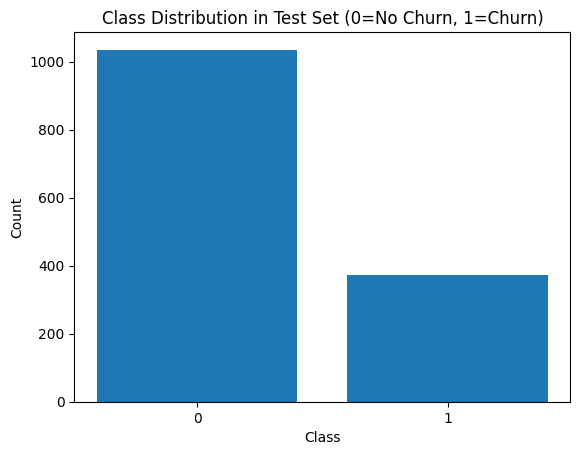

In [13]:
# =========================
# 1) Class distribution (Target imbalance)
# =========================
plt.figure()
vals, counts = np.unique(y_test, return_counts=True)
plt.bar(vals.astype(str), counts)
plt.title("Class Distribution in Test Set (0=No Churn, 1=Churn)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
#The dataset is imbalanced, with significantly more non-churn customers than churn customers.

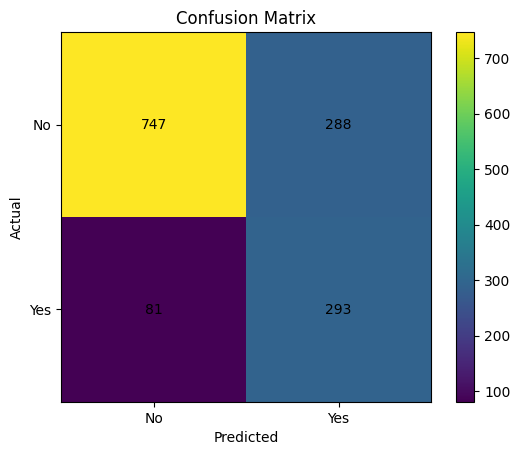

In [14]:
# =========================
# 2) Confusion Matrix (as heatmap)
# =========================
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.show()
#The model prioritizes catching churn customers, which increases false positives

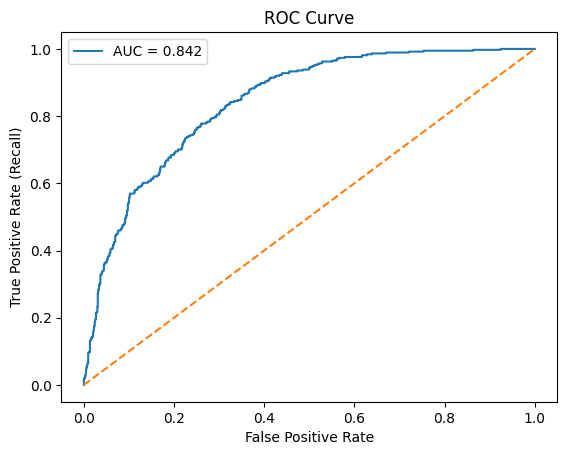

In [15]:
# =========================
# 3) ROC Curve + AUC
# =========================
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()
#The ROC curve shows that the model has good overall discrimination ability.

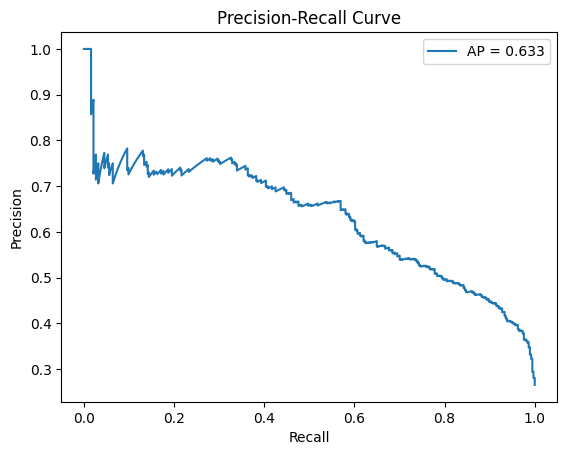

In [16]:
# =========================
# 4) Precision-Recall Curve + AP
# =========================
prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
#There is a trade-off between identifying most churners and maintaining prediction precision.

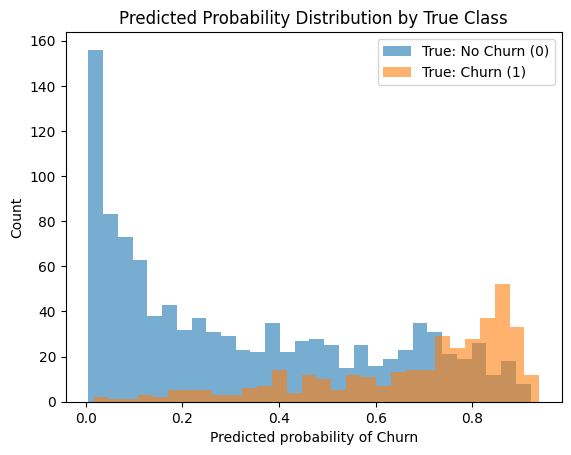

In [17]:
# =========================
# 5) Probability distribution by true class
#    (why we get many false positives)
# =========================
plt.figure()
plt.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label="True: No Churn (0)")
plt.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label="True: Churn (1)")
plt.title("Predicted Probability Distribution by True Class")
plt.xlabel("Predicted probability of Churn")
plt.ylabel("Count")
plt.legend()
plt.show()
#The overlap in predicted probabilities explains the high number of false positives.


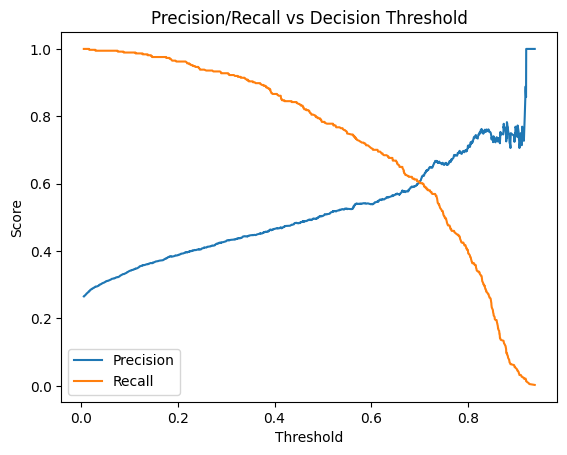

In [18]:
# =========================
# 6) Threshold vs Precision/Recall (before improvement)
# =========================
# thr has length = len(prec)-1, so align:
thr_plot = thr
prec_plot = prec[:-1]
rec_plot = rec[:-1]

plt.figure()
plt.plot(thr_plot, prec_plot, label="Precision")
plt.plot(thr_plot, rec_plot, label="Recall")
plt.title("Precision/Recall vs Decision Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()
#Adjusting the decision threshold allows controlling the trade-off between precision and recall.

<Figure size 600x400 with 0 Axes>

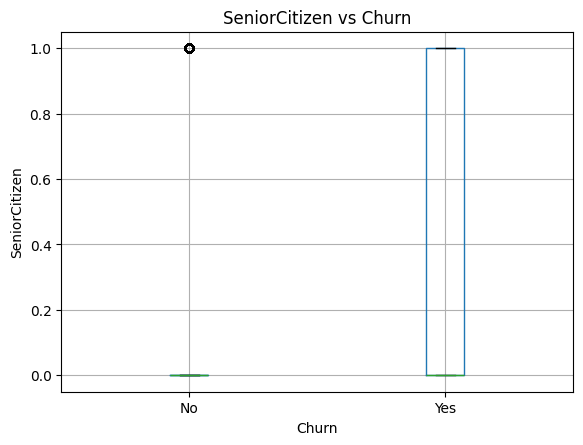

<Figure size 600x400 with 0 Axes>

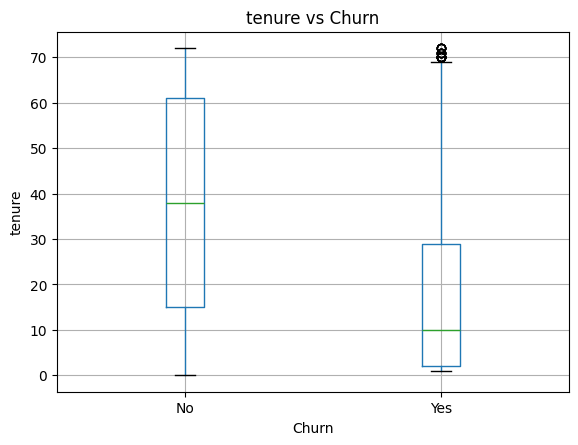

<Figure size 600x400 with 0 Axes>

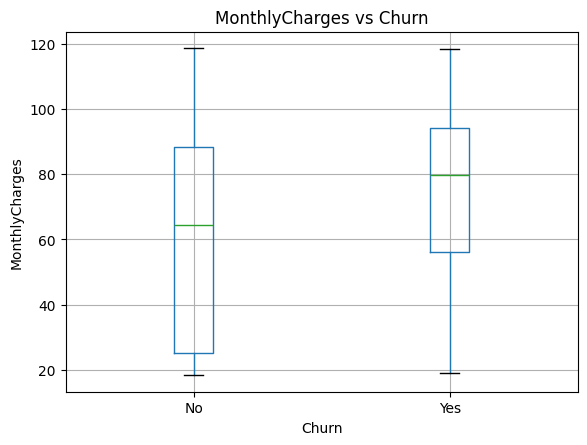

<Figure size 600x400 with 0 Axes>

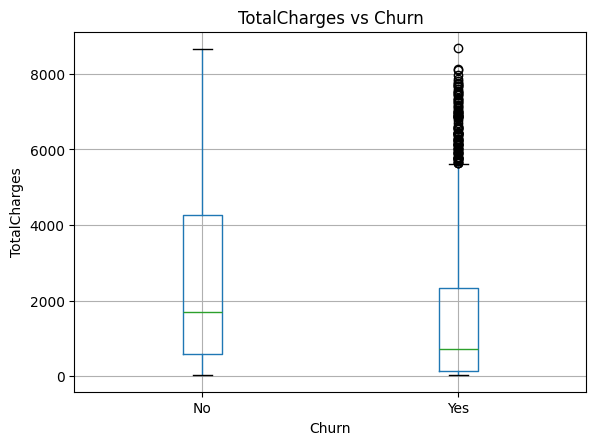

In [21]:
import matplotlib.pyplot as plt

# تأكدي إن df يحتوي على Churn بصيغة Yes/No أو 0/1
# إذا Churn عندك 0/1 وتبينه Yes/No للعرض:
# df_plot = df.copy()
# df_plot["Churn"] = df_plot["Churn"].map({0:"No", 1:"Yes"})
# غير كذا استخدمي df مباشرة

df_plot = df.copy()

# لو Churn نصي (Yes/No) نخليه مرتب في الرسم
if df_plot["Churn"].dtype == "object":
    order = ["No", "Yes"]
else:
    order = [0, 1]

# الأعمدة الرقمية (الأصح تستخدمين num_cols اللي سويناه في البايبلاين)
num_cols = df_plot.drop(columns=["Churn"], errors="ignore").select_dtypes(exclude="object").columns

for col in num_cols:
    plt.figure(figsize=(6, 4))
    df_plot.boxplot(column=col, by="Churn")
    plt.title(f"{col} vs Churn")
    plt.suptitle("")
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.show()
